<h1>Image Colorizer *Very work in progress*</h1><hr>
<h3>Jason Lombino - Capstone Project Submission</h3>

<h1>BentoColor</h1>

<p style='color:red'>Logo or graphics go here</p>

<p>
BentoColor is widely known thoughout the broadcasting industry for their colorization of classic TV shows and movies.
</p>

<p>
Given the recent streaming boom, every broadcasting company is racing to add their entire library of shows and movies to their respective platform. In order to expand libraries and make their paltforms more appealing, BentoColor is recommending that companies add popular pre-color shows and movies to their services.
</p>

<p>
While BentoColor has dozens of talented artists ready to work on these projects, the recent explosion of AI art has led BentoColor to question whether AI could be an effective tool in colorizing old movies and TV shows. A successful implementation of AI colorization tools can greatly assist artists in reviving old black and white series and movies. With enough investment into these technologies, it is possible that the AI colorization tools can perform a great deal of the artist's responsibilities allowing to tackle more works in the same period of time.
</p>

<p>
BentoColor aims to become a leader in the field of colorization by leveraging their artists' increased productivity to acquire more lucrative colorization contracts from major players in the broadcasting business.
</p>

<h1>Getting Colorization Working</h1>

<h3>The Current Situation</h3>
<p>
Colorization is the process of converting a black and white image or video into a partially or fully colored one. There are many techniques currently in use to accomplish this process for videos. Manual colorization where artists color each frame or image individually has mostly fallen out of favor due to advancements in colorization algorithms. Typically now, artists or technicians are able to assign colors for regions of the frame and an algorithm will track that region between frames and continue applying that same color or variations of it depending on brightness. This is still very time consuming for technicians because they need to assign the colors to each of the initial frames in each scene and then to each object or section that enters the scene later. They also need to verify that the algorithm is applying the correct colors and make any corrections necessary to the output.
</p>
<p>
BentoColor aims to address the issues with state of the art colorization technology by automatically detecting what color the objects in each frame should be. This can be used for each frame independantly, or be used in conjunction with the current technology to track the generated colors throughout the scene.
</p>

<h3>BentoColor Technology</h3>
<p>
In order to automatically colorize images and video frames, BentoColor will utilize a neural network. Specifically, Bentocolor will utilize an architecture similar to the U-net architecture described in <a href=https://arxiv.org/pdf/1505.04597.pdf>this paper</a> and <a href=https://www.tensorflow.org/tutorials/generative/pix2pix>this tutorial</a>. The U-net architecture is composed of a downsampling section which extracts features from the input image, an upsampling section which determines what color should be applied to each feature, and skip connections between them which allow the neural network to pass information about important patterns in the image forward.
</p>
<h1>Image and Video Data</h1>

<p style='color:red'>a couple example pictures go here</p>

BentoColor used two sources of data for this project. 
<p>
<a href=https://www.kaggle.com/datasets/utkarshsaxenadn/landscape-recognition-image-dataset-12k-images>This dataset</a> from kaggle was used to develop a proof-of-concept model capable of fully colorizing images. The dataset contains 12,000 images of landscapes that fall into five categories:
Coast, Desert, Forest, Glacier, and Mountain. These images were divided into a training set containing 10,000 images, a validation set containing 1,500 images, and a test set containing 500 images. While training and testing this model, due primarily to a lack of computing resources, the resolution of these images was reduced to 64x64 pixels. The images were also augmented before being shown to the model by randomly rotating and flipping them around both the horizontal and vertical axes. This was done to prevent the model from overfitting as well as to increase the effective number of images the model could train on.
</p>

<p style='color:red'>maybe example frame or logo for dusty go here</p>

<p>
The television show <a href=https://en.wikipedia.org/wiki/Dusty%27s_Trail>Dusty's Trail</a> is the second source of data used for this project. This was chosen primarily because it is one of very few colored television shows or movies which are public domain. Training data was extracted from episodes 3 through 6 using FFmpeg. Eight frames were extracted per second of video resulting in approximately 11,000 frames per 22-ish minute episode.
</p>

<code>ffmpeg -i 'Input Video Path' -vf fps=8 'Output Image Path .jpeg'</code>
<p>
These frames were then converted to 64x64 pixels due to a lack of computing power available to train a larger model. The same augmentations were performed as to the landscape images; each image could be randomly rotated or flipped around either axis. The rotation was potentially unnecessary as the orientation of objects in this television show is typically right-side-up as opposed to the landscape dataset.
</p>

<h3>Color Formats</h3>

<p>
In addition to being scaled down to 64x64 pixels and flipped or rotated, the image data was further transformed. The LAB color space was selected for this work rather than the RGB color space, so each image needed to be converted to this color space using the <a href=https://pypi.org/project/opencv-python/>opencv package</a>. The LAB color space was selected because it encodes the image as a grayscale part (L channel) and two color parts (A and B channels). This was helpful because the L channel could be extracted from the newly encoded image and used as the input for the model while training. In addition, the model would only need to predict two values (A and B) for the image color as opposed to the three it would need to predict for RGB. The original L channel could be re-combined with the model predicted A and B channels to produce the fully colorized image.
</p>


<h1>Model Training and Loss</h1>

<h3>Mean Squared Error</h3>

<p>
Training began with the landscape colorizing model. The first attempt at training the model used a mean squared error loss function with the simple goal of making the output colorized image as close to the original color image as possible. Colorized images from the test set resulting from this model can be seen below alongsize the original color and original grayscale images that they were produced from. While this method worked reasonably well, the model tended to overfit to the training images, and images from the validation set appeared less vibrant and more washed-out than the original color images in general.
</p>

<p>
<b>More information on the model trained using mean squared error as well as the code used to train this model can be found in <a href=./MSE_Colorizer.ipynb>this notebook</a>.</b>
</p>

<p style='color:red'>MSE formula? go here</p>

<p>The chart below shows the model's (mean squared error) loss plotted against the number of epochs the model was trained for. The clear downward trend signals that the model's output images are getting closer to the original images. The training of this model was ended because the improvements in loss were beginning to slow down and training the model for much longer could easily lead to overfitting.
</p>

<p style='color:red'>Tensorboard stuff goes here</p>

<h3>Generative Adversarial Networks</h3>

<p>
A modified GAN (Generative Adversarial Network) architecture based on <a href=https://arxiv.org/pdf/1611.07004.pdf>this paper</a> was the next step in training the colorization model. Rather than trying to make the input and output images as close as possible on a pixel-value level, the GAN architecture is actually composed of two neural networks. One network is the original U-net generator, and the other network is a standard convolutional neurual network or discriminator.
</p>

<p>
The generator has the goal of colorizing the images in this architecture, and can be thought of as a forger making fake colored images.
</p>
<p>The discriminator has the goal of determining whether a color image provided to it was produced by the generator. It can be thought of as a policeman.
</p>

<p>
The generator and disciminator are set against eachother in this case. The generator trains to produce images that the discriminator thinks are original or genuine. The discriminator trains to tell the images the generator produces apart from the genuine ones. As the generator gets better at producing realistic looking images, the discriminator needs to get better at telling them apart from real ones. This leads to a loop of both models constantly improving until the generator colorized images are actually indistinguishable from the real images.
</p>

<p style='color:red'>GAN policeman and forger image go here</p>

<h3>Advantages of GANs</h3>

<p>
The main advantage of using a GAN is that they are able to generate data that is very similar to existing data. If the generator is able to fool a well trained discriminator, it is highly likely that it will be able to fool an untrained person. GANs are also capable of producing decent results when the training dataset is smaller than desired. They are excellent at picking up on and reproducing similar patterns to those present in the training data.
</p>

<h3>Disadvantages of GANs</h3>

<p>
GANs are very difficult to train and have a variety of potential failure modes. One example is if either the generator or discriminator are too strong relative to the other, the weaker neural network will not be able to learn well. This is more of an issue for the generator because the discriminator's job is typically easier at the beginning of training when the generator is producing poorly colorized images. For this reason, the loss function for the generator also included a scaled factor of mean squared error to push it in the right direction at the start.
</p>

<p>
Because GANs are composed of two neural networks, they take even longer to train than the typical model. While the optimal number of epochs or time for training depends on your model architecture and dataset, it is not uncommon for neural networks, let alone GANs to take many hours to converge. Therefore, it is vital to select sizes for each neural network and for the dataset that will allow for convergence within a reasonable amount of time on the available hardware. This is further complicated because it is difficult to know how long it will take to train a neural network before attempting to train it. It is advisable to not use too small of a dataset or resolution, however as the neural network will not learn well if there is not enough information for it to learn from or not enough parameters in the network to learn most of the patterns present within the data.
</p>

<p>
The four charts below show the discriminator loss, generator loss(adversarial), generator loss (based on MSE), and total generator loss respectively.
</p>

<ul>
<li>The discriminator loss starts high and gets lower over time as the discriminator learns to tell the generator's fabrications apart from the original images.</li>
<li>The generator's adversarial loss is the inverse of the discriminator's loss. It goes up over time because the generator's job is much harder than the discriminator's so it learns slower.</li>
<li>The generator's MSE loss goes down over time as the generated images get closer to the original images. It eventually flattens out and increases slightly as the generator learns from the discriminator rather than the mean squared error. This is what allows the images to become so vibrant and detailed.</li>
<li>The generator's total loss is the weighted sum of the adversarial and MSE components. The MSE component is larger initially, but the adversarial component eventually takes over.</li>
</ul>


<p style='color:red'>Tensorboard stuff goes here</p>

<p>
<b>More information on the model trained using the GAN architecture (with a mean squared term in the loss function) as well as the code used to train this model can be found in <a href=./GAN_Colorizer.ipynb>this notebook</a>.</b>
</p>

<h3>Other Issues</h3>

<p>
There are a few other issues associated with colorization which are not exclusive to machine learning. For example, what color is a shoe? This is a harder question to answer than it seems because there really is no typical shoe color. While the typical boot may be brown, one could color it black or light beige and no one would think twice about it. This may seem like it would make the task of colorization easier, but in fact it just makes the patterns more difficult to detect if the machine learning model sees the same shoe in many different colors. This applies to many common objects, not just clothing and is a substantial issue with machine learning based colorization.
</p>

<p style='color:red'>same boots in different colors go here</p>

<h1>Image Colorization Results</h1>

<p>
Results for both the mean squared error only model, and the GAN model can be seen below. The leftmost image is the grayscale image that was input into both models. The middle two images are the output of each respective model. The rightmost image is the original image in full color. 
</p>

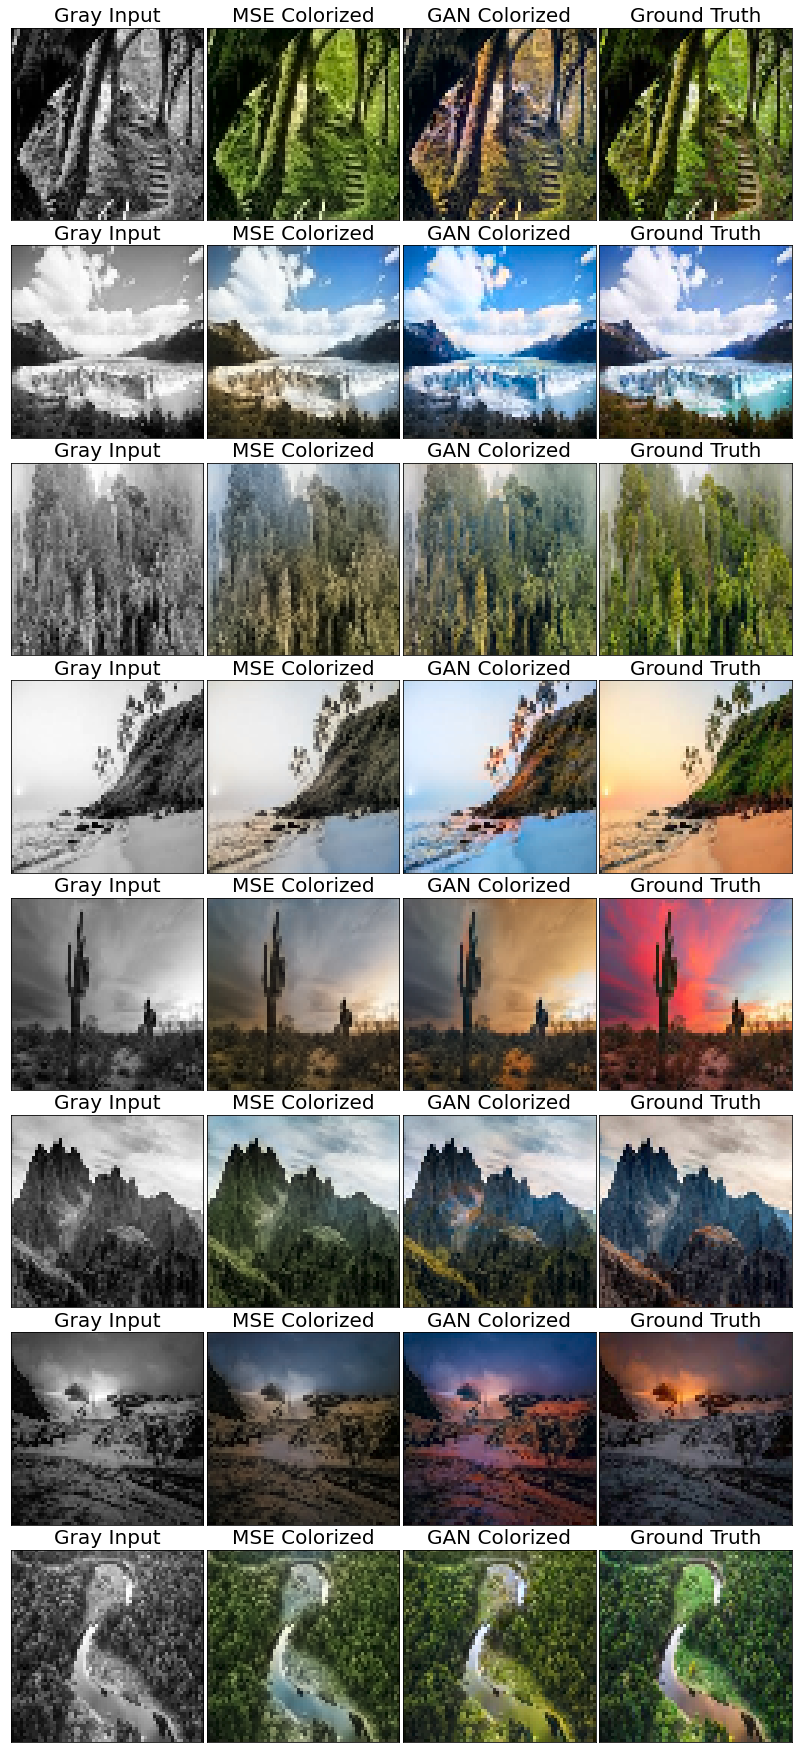

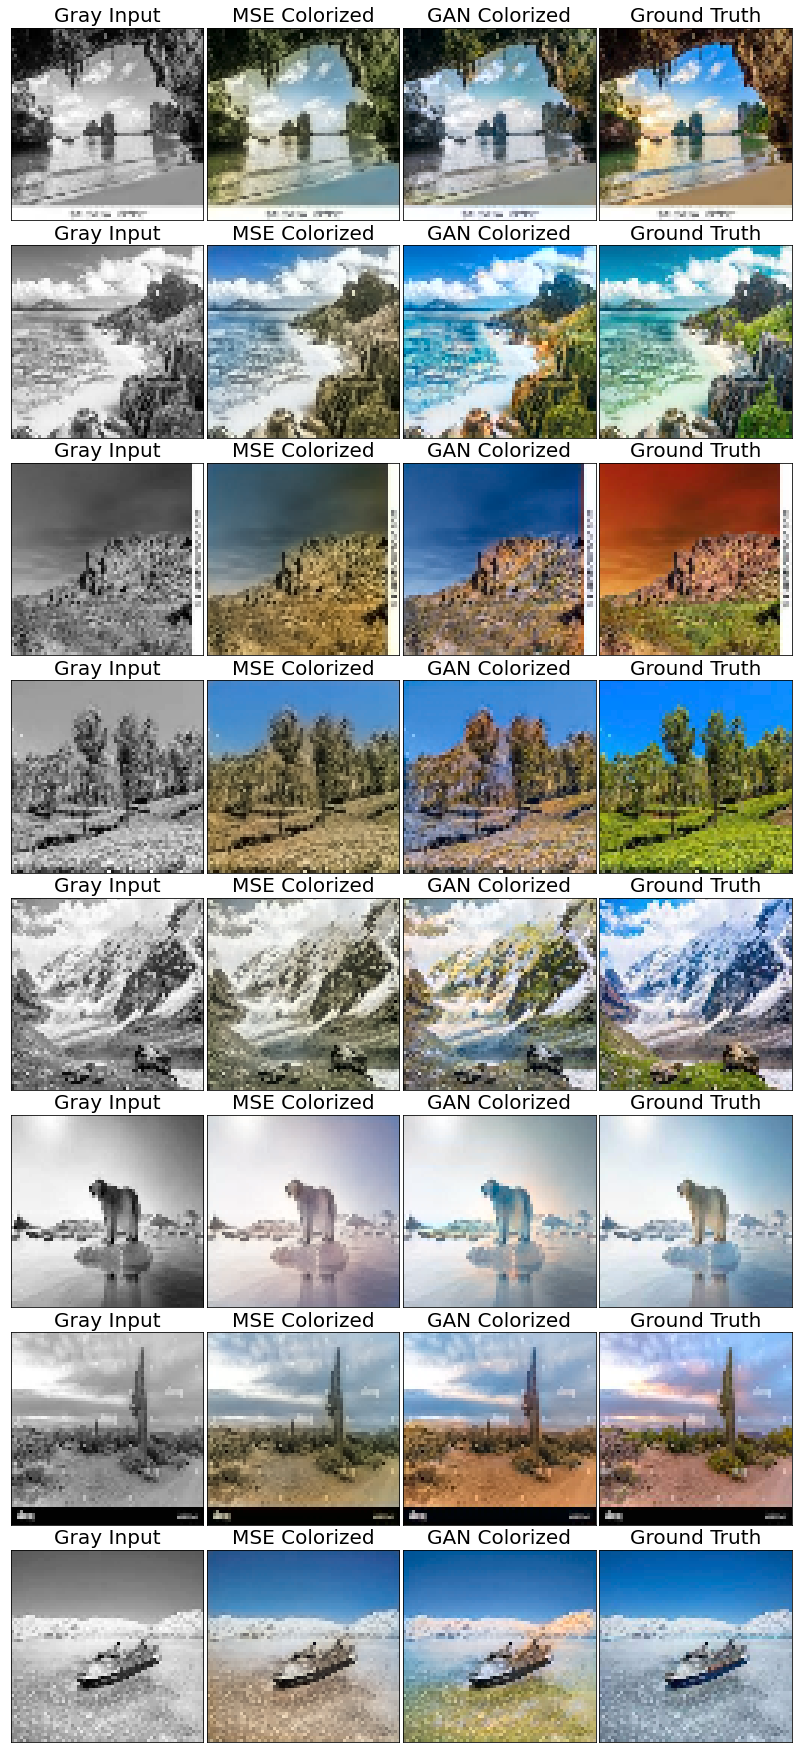

In [2]:
from keras.models import load_model
import colorizerutils as utils

mse_gen = load_model('models/1-5-23/mse/generator.h5')
gan_gen = load_model('models/1-5-23/gan/generator.h5')

for test_batch in range(2):
    test_images = utils.image_loader(directory='../images/test_images/',
     batch_size=8,training=False).__getitem__(test_batch)
    utils.display_images(gray_channel=test_images[0],color_channels=test_images[1],
    generator1=mse_gen,gen1_title='MSE Colorized',generator2=gan_gen,gen2_title='GAN Colorized');

<h3>Interpreting the Results</h3>

<p>
<b>The interpretation of these results and the relative success of each model is highly subjective. Each person viewing the results may prefer a different colorization for any number of reasons.</b>
</p>

<p>
There are several important questions to ask when determining how well a given model can colorize images. Here are a few important ones one should consider when assessing these models:
</p>
<ul>
<li>How close are the colors in the model's test output to the test image's original colors?</li>
<li>Are the differences in the model's test output to the test image's original colors reasonable or expected?</li>
<li>Are there any major defects in the model's output (random lines, splotches, ect...)?</li>
<li>Are the produced colors vibrant or dull when either is appropriate?</li>
<li>Is there an appropriate variety of color to capture the detail in each image</li>
</ul>

<p>
In this case, there are not many major defects in most of the colorized images. The GAN seems to be producing more vibrant and detailed images while the model trained using mean squared error seems to be using fewer colors overall. The GAN also seems to be segmenting most of the images into its constituent subjects better and coloring each of them differently while the model trained using mean squared error tends to select one predominant color and apply that to more of the image. The GAN does seem more likely to deviate from the colors in the original test image, but it often uses colors that could also be appropriate for the objects in scene.
</p>

<p><b>
For these reasons, the GAN will be the primary model utilized for colorizing videos.</b>
</p>

<h1>Applying to Movies and TV Shows</h1>

<p>
Following the success of using a GAN to colorize still images, BentoColor has decided to utilize the same technology for video colorization. This is possible because a video is in essence just a series of frames which are still images. If each of these images can be successfully colorized, they can theoretically be arranged to form a fully colorized video. </p>

<p>
Unsurprisingly, colorizing videos poses its own unique challenges. If a video is colorized frame-by-frame there is no guarantee that there will be any consistency between the frames in each scene. Regredless of how nice each frame looks independently, this can lead to a choppy or flashing video which is not acceptable in a colorization product for videos. This can be highly detrimental if additional strategies aimed at mitigating this are not employed.
</p>

<h3>Using the GAN</h3>

<p>BentoColor will utilize a U-Net model trained with the same GAN architecture described in the image colorization section. Once again, the GAN was selected because it seems to be producing more vibrant and detailed images than the model trained using only mean squared error. A lower weight for the mean squared error was used in the loss function for this GAN. This was done because the training images were less varied than in the previous GAN's case. BentoColor feared that relying too heavily on mean squared error for loss in this case would lead to overfitting so adversarial loss was prioritized.
 </p>

<p>
Similar to the previous gan, he four charts below show the discriminator loss, generator loss(adversarial), generator loss (based on MSE), and total generator loss respectively.
</p>

<ul>
<li>The discriminator loss starts high and gets lower over time as the discriminator learns to tell the generator's fabrications apart from the original images.</li>
<li>The generator's adversarial loss is overall lower than the original GAN's. This is likely because there is less diversity in the training images making the generator learn more quickly.</li>
<li>The generator's MSE loss is also lower overall than the original GAN's. Once again, this is likely because there is less diversity in the training images making the generator likely to overfit.</li>
<li>The generator's total loss is the weighted sum of the adversarial and MSE components (different weights than the previous GAN). The MSE component is larger initially, but the adversarial component eventually takes over.</li>
</ul>

<p style='color:red'>Tensorboard stuff goes here</p>

<p>
<b>More information on the model trained using the GAN architecture (with a mean squared term in the loss function) as well as the code used to train this model can be found in <a href=./Dusty_Colorizer.ipynb>this notebook</a>.</b>
</p>

<table>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
        <td><img src=resources/video/test_2_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_2_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_2_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_7_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_7_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_7_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_18_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_18_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_18_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/test_28_grayscale.gif width=256></img></td>
        <td><img src=resources/video/test_28_colorized.gif width=256></img></td>
        <td><img src=resources/video/test_28_original.gif width=256></img></td>
    </tr>
</table>

<h3>Interpreting the Results</h3>

<p>
<b>The interpretation of these results and the relative success of each model is highly subjective. Each person viewing the results may prefer a different colorization for any number of reasons.</b>
</p>

<p>The video colorizing model can be assessed by asking many of the same questions as before:</p>

<ul>
<li>How close are the colors in the model's test output to the test image's original colors?</li>
<li>Are the differences in the model's test output to the test image's original colors reasonable or expected?</li>
<li>Are there any major defects in the model's output (random lines, splotches, ect...)?</li>
<li>Are the produced colors vibrant or dull when either is appropriate?</li>
<li>Is there an appropriate variety of color to capture the detail in each image</li>
</ul>

<p>
With videos, however consistency and stability of the colors between frames is also extremely important. While many frames look good and most of the colors are in the correct places, the inconsistency between frames is definitely substantial and a major weakness of this model.
</p>

<p>
While this model was trained on over 40,000 frames, many of these frames are likely from the same scenes with only small variations in color. While BentoColor did their best augmenting the image data with random flips and rotations, there is only so much that can be expected from a model trained using limited data and computing power. It also does not look like the GAN has converged completely and could run for thousands of more epochs before it would. This is apparent in the tensorboard logs above where both the generator adversarial loss and discriminator loss have not reached a steady state. It is impossible to know whether this would lead to better results or more overfitting though.</p>

<h1>Recommendations</h1>

The most important recommendation is for BentoColor to make partnerships with image and movie rightsholders to acquire more video data. Subsizide early colorizations in exchange for rights to train future models on shows and movies owned by these partners. This will help BentoColor acquire new customers and form relationships with them as well and provide the necessary data to train the next generation models.

As far as the model itself, BentoColor should look into imcorporating a classifier into the U-net as proposed by <a href=https://arxiv.org/abs/1712.03400>this paper</a>. Currently, the model does not know what it is actually coloring and is only selecting colors based on patterns of pixels in the image. Incorporating a classifier could give the model context into what it is actually "looking at" in different parts of the image improving its performance especially when multiple objects are in frame. This was impossible to incorporate for this project because most pre-trained classifiers that the paper suggests using require an image resolution higher than my workstation can handle. Additional technical challenges with incorporating this into the model include color space conversions and selecting the appropriate pre-trained classifier for the subject the model will be colorizing.

Finally, while the colorization model is definitely not ready for production, it can be used to seed current techniques. While the model does not do well with videos, it colorizes pictures reasonably well. The model can be used to create seed frames that can help artists using current colorization techniques with inspiration and give them a starting point. It is unclear whether fully automatic AI image and video colorization will be possible in the near future, but the incomplete version can still be a very useful tool in the hands of talented technicians and artists today.